## Einleitung
Question and Answer Generation (QAG) ist ein wichtiger Anwendungsfall, bei dem automatisch Fragen und Antworten zu einem gegebenen Text generiert werden.
### Use-Case
QAG hat viele praktische Anwendungen:

- Content-Erstellung: QAG kann Content-Erstellern und Autoren dabei helfen, Inhalte effizienter zu erstellen. Anstatt manuell Fragen und Antworten zu einem Text zu formulieren, kann QAG dies automatisch erledigen.
- E-Learning: In Bildungseinrichtungen und E-Learning-Plattformen kann QAG verwendet werden, um Übungen und Quizfragen zu generieren, die das Verständnis der Schüler und Lernenden fördern.
- FAQ-Generierung: Unternehmen können QAG nutzen, um FAQs für ihre Produkte oder Dienstleistungen zu erstellen. Das spart Zeit und Ressourcen bei der Pflege von Kundenunterstützungsseiten.
- Chatbots und Virtual Assistants: QAG kann dazu verwendet werden, um Chatbots und virtuellen Assistenten die Fähigkeit zu geben, auf natürliche Weise gestellte Fragen zu beantworten.

Wir fokussieren den Use-Case dieser Arbeit auf E-Learning.
### Zielsetzung

Die Zielsetzung ist: Die Entwicklung eines QAG-Modells, das in der Lage ist, qualitativ hochwertige Fragen und Antworten auf Texte von CNN (https://huggingface.co/datasets/StellarMilk/newsqa) zu generieren.

### Github Repo
Es wurden diverse Repositorys untersucht. Einzelne davon wurden auch getestet. Die Modelle konnten jedoch nicht reproduziert werden. Das für das Training verwendete Repository ist https://github.com/asahi417/lm-question-generation.

### Metriken
Das Repository speicher eine Reihe von Metriken: BLEU 1-4, ROUGE-L, BERT-Score, MoverScore sowie QAA-Aligned Precision, Recall und F1-Score, basierend sowohl auf dem BERT-Score als auch auf dem MoverScore. In diesem Abschnitt werden die Funktionsweisen dieser Metriken erläutert und ihre Relevanz für den spezifischen Use-Case aufgezeigt, um zu bestimmen, welche davon analysiert werden sollten. Alle diese Metriken weisen einen Wertebereich von 0 bis 1 auf.
#### Bleu Score 1-4 (https://aclanthology.org/P02-1040.pdf)

Der Bleu Score wird mit ein bis 4 Grams berechnet. Zuerst wird die N-Gramm-Übereinstimmung berechnet. Der BLEU Score misst, wie viele N-Gramme in der maschinellen Übersetzung mit denen in der Referenzübersetzung übereinstimmen. Um zu verhindern, dass identische N-Gramme in der Übersetzung mehrmals gezählt werden, wenn sie in der Referenzübersetzung nur einmal vorkommen, wird ein Clipping-Mechanismus verwendet. Dies bedeutet, dass die Anzahl der Übereinstimmungen für jedes N-Gramm auf das Maximum in einer der Referenzübersetzungen beschränkt wird. Für jedes N-Gramm wird zuletzt die Precision berechnet, indem die Anzahl der geclippten Übereinstimmungen durch die Gesamtzahl der N-Gramme in der maschinellen Übersetzung geteilt wird.

Obwohl diese Metrik nicht optimal ist, wie zum Beispiel, dass sie den Sinn nicht erkennt und Synonyme als falsch betrachtet, ermöglicht sie eine schnelle einfach erklärbare Übersicht der Präzision der erstellten Fragen und Antworten. Darum wird diese Metrik berücksichtigt.

#### Rouge L

Rouge L berechnet die längste gemeinsame Subsequenz geteillt durch die maximal mögliche Sequenz. Dabei werden ungleiche Wörter, welche dazwischen vorkommen übersprungen. 

Der Rouge L Score hat ein zusätzliche Aussagekraft gegenüber dem Bleu Score, da es die Gesamte Sequenz betrachtet. Da sowohl der Rouge L wie auch der Bleu Score auf exakte Wortübereinstimmung gehen, wird zur vereinfachung nur der Bleu-Score analysiert.

#### Bert Score (https://arxiv.org/pdf/1904.09675.pdf)

Beim Bert Score wird sowohl der Referenztext, wie auch der generierte Text in Bert-Embeddings übersetzt. Danach werden von allen Wörtern des Referenztext zu allen Wörtern des generierten Textes eine Pairwise Cosine Similarity berechnet. Die maximale Ähnlichkeit pro Wort wird weiterverwendet, um den F-Bert Score zu berechnen.

<img src="./images/Bert Score.png" alt="Bert Score" width="1000">

Der Bert Score kann zwar Synonyme erkennen, jedoch spielt die Reihenfolge der Wörter weiterhin keine Rolle. 


#### Mover Score (https://arxiv.org/pdf/1909.02622.pdf)


Der Mover Score berechnet zuerst auch die Bert Embeddings, sowohl für den Referenztext, wie auch für die Bert-Embeddings. Danach wird die Wasserstein-Distanz berechnet. Dies ist eine Methode, um die Distanz zweier Wahrscheinlichkeitsverteillungen zu berechnen.

Im Vergleich zum Bert-Score kann mit dem Moverscore der Gesamtsinn besser bewertet werden. Dies kann mit den anderen Metriken nicht abgedeckt werden und ist relevant für die Evaluation.

#### QAA-Aligned Scoring

Bei QAA-Aligned Scores wird jeweils die beste von allen möglichen Kombinationen verwendet. Wenn wie in den Newsqa Daten auch länger Sätze verwendet werden, macht dies Sinn, da unterschiedliche Fragen und Antworten generiert werden können.

#### Ausgwählte Metriken

Zusammengefasst wird der Bleu Score 1-4 und der QAA-Aligned Mover Score für die Evaluation verwendet. 



## Modellarchitektur

Um den Use- Case möglichst gut abzudecken sind wir auf das Paper von Asahi Ushio and Fernando Alva-Manchego and Jose Camacho-Collados gestossen (https://arxiv.org/pdf/2305.17002.pdf), welches unterschiedliche QAG models vergleicht. 

Das beste beschriebene Modell aufgrund von der Metrik F1/exact match, welches in der Tabelle 2 beschrieben wird ist die T5- end-end Architektur. Zusätzlich zu den besseren Metriken sind die Trainingskosten beim end-end Aufbau besser.

### End-End Ansatz
Es gibt unterschiedliche QAG-Ansätze. In diesem Bericht wird der Ansatz End2End verwendet, welcher innerhalb eines Modelles und in "einem Schritt", sowohl die Frage, wie auch die Antwort erstellt.

<img src="./images/qag.png" alt="Aufbau" width="500">

### T5- Transformer

Der T5- Transformer wird im Paper "Exploring the Limits of Transfer Learning with a Unified
Text-to-Text Transformer" (https://jmlr.org/papers/volume21/20-074/20-074.pdf) beschrieben.

Diese Modelle werden vortrainiert, um dann auf Downstream Tasks angewendet werden zu können. Dabei werden alle Aufgabenstellungen als text-to-text Problem angesehen. Dadurch könnten sehr unterschiedliche Fragestellungen abgebildet werden.

<img src="./images/T5-Aufbau.png" alt="Aufbau" width="700">

Die Modellarchitektur ist sehr ähnlich wie der ursprüngliche Transformer (https://arxiv.org/pdf/1706.03762.pdf), es wurden aber einzelne Änderungen gemacht:
- Layer Normalization: Es wird nur eine vereinfachte Layer-Normalisierung verwendet, welche die Aktivierungen umskaliert, ohne additive Bias hinzuzufügen.
- Dropout: Es wird an unterschiedlichen stellen Dropout eingesetzt.
- Embedding: Der ursprüngliche Transformer verwendent ein Sinusförmiges Embedding oder ein gelerntes Positionsembedding. In diesem Aufbau wird ein relatives Positionsembedding verwendet.

Es gibt noch weitere kleinere Anpassungen. Im grossen und ganzen entspricht es der ursprünglichen Transformerarchitektur. Zudem wird ein Sentencepiece Tokenizer (https://arxiv.org/pdf/1808.06226.pdf) verwendet, welcher auf Unigrams basiert.

#### Modellgrössen

Es wurden die Small und Base Varianten untersucht. Diese haben folgende Parameter:

| Modeltyp | Output Dimensionalität MLP pro Block | Anzahl Encoder und Decoder Layer |sub-layers and embeddings Dimension|Anzahl Parameter|
| :----:   | :---:                                | :-------: |:-------:|:-------:|
| Small    | 2048                             |    6     |512|60 * 10^6|
| Base     | 3072                                  |    12   |768|220 * 10^6|

#### Pretraining

Beim Pretraining wurden 15 % der Tokens angepasst. Diese 15 % werden mit einer durchschnittlichen Spanlänge von 3 mit einer Maske ersetzt.

Objective |Inputs| Targets
| :-------: |:-------:|:-------:|
replace spans  |Thank you \<X\> me to your party \<Y\> week . |\<X\> for inviting \<Y\> last \<Z\>

### Packages

In [5]:
import utils
import re
import string
import random
from collections import Counter

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import transformers
from datasets import load_dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
tokenizer = transformers.AutoTokenizer.from_pretrained("lmqg/t5-small-squad-qag")
tokenizer_info = {
    "Tokenizer Type": type(tokenizer).__name__,
    "Pretrained Model": tokenizer.name_or_path,
    "Vocabulary Size": tokenizer.vocab_size,
    "Model Max Length": tokenizer.model_max_length,
    "Padding Side": tokenizer.padding_side,
    "Special Tokens": tokenizer.special_tokens_map
}

print(tokenizer_info)

tokenizer_config.json:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

c:\dev\npr_mc2\.venv\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\flori\.cache\huggingface\hub\models--lmqg--t5-small-squad-qag. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/20.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

{'Tokenizer Type': 'T5TokenizerFast', 'Pretrained Model': 'lmqg/t5-small-squad-qag', 'Vocabulary Size': 32100, 'Model Max Length': 512, 'Padding Side': 'right', 'Special Tokens': {'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<ex

## Datengrundlage

Der Newsqa Datensatz (https://www.microsoft.com/en-us/research/project/newsqa-dataset/) von Microsoft wurde auf das Format vom Github Repository angepasst und auf Huggingface hochgeladen (https://huggingface.co/datasets/StellarMilk/newsqa).

Das NewsQA-Datenset wurde erstellt, indem CNN-Nachrichtenartikel aus dem DeepMind Q&A-Datensatz genutzt wurden. Es enthält 120.000 Frage-Antwort-Paare, die von Crowd-Quellen generiert wurden. In diesem Datenset sind die Dokumente die CNN-Nachrichtenartikel selbst, die Fragen wurden von menschlichen Benutzern in natürlicher Sprache verfasst, und die Antworten können aus mehreren Worten des ursprünglichen Textes bestehen. Es ist jedoch zu beachten, dass einige Fragen möglicherweise nicht beantwortet werden können. In dem von uns einfach zugänglichen Datensatz sind noch 78372 Observationen mit beantwortbaren Fragen.

Die Sammlung von NewsQA erfolgte in einem sorgfältigen dreistufigen Prozess. In der ersten Stufe sehen die Fragesteller lediglich die Überschrift und die Höhepunkte eines Artikels. In der zweiten Stufe sehen die Antwortgeber die Frage und den vollständigen Artikel, aus dem sie eine passende Antwortpassage auswählen. Schließlich, in der dritten Stufe, bewerten Validatoren den Artikel, die Frage und eine Reihe von Antworten. Dieser Ansatz macht das NewsQA-Datenset natürlicher und anspruchsvoller als frühere Datensätze.

In [7]:
dataset = load_dataset("StellarMilk/newsqa")

In [8]:
number_of_answers = [len(answers) for answers in dataset["train"]["answers"]]
number_of_questions = [len(answers) for answers in dataset["train"]["questions"]]
assert sum(np.array(number_of_answers) != np.array(number_of_questions)) == 0
assert len(set(dataset["train"]["paragraph"])) == len(dataset["train"]["paragraph"])

#### Verteillung der Anzahl Fragen, Antworten und CNN-Texte

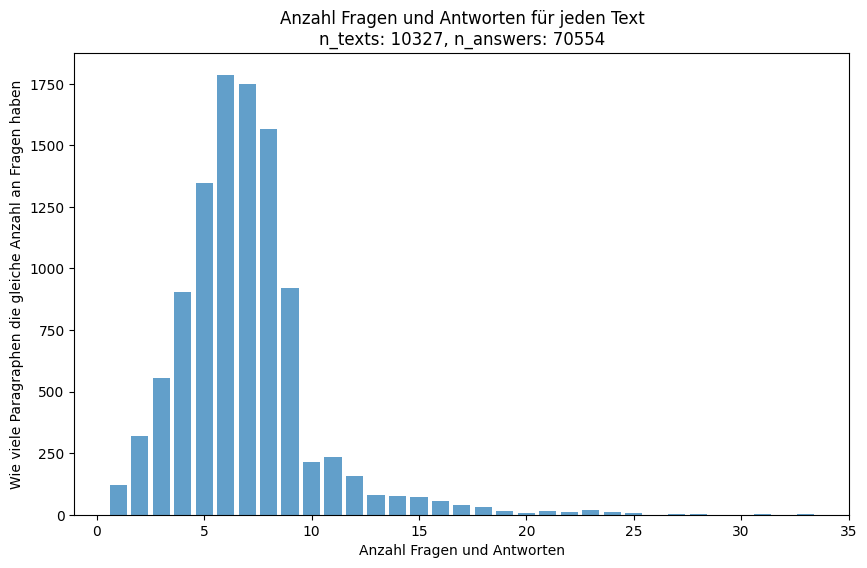

In [9]:
number_counts = Counter(number_of_answers)

unique_numbers = list(number_counts.keys())
counts = list(number_counts.values())

plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.bar(unique_numbers, counts, align='center', alpha=0.7)
plt.xlabel('Anzahl Fragen und Antworten')
plt.ylabel('Wie viele Paragraphen die gleiche Anzahl an Fragen haben')
plt.title(f'Anzahl Fragen und Antworten für jeden Text\nn_texts: {len(number_of_answers)}, n_answers: {sum(number_of_answers)}')
plt.show()

Die Texte haben eine stark unterschiedliche Anzahl von Fragen und Antworten. Dies könnte bei den Texten, welche wenige Fragen und Antworten haben, dazu führen, dass das Modell die Fragen und Antworten schneller lernt und somit zu Overfitting führen könnte.

In [10]:
qa = [len(qa.split("|")) for qa in dataset["train"]["questions_answers"]]
qa_set = [len(set(qa.split("|"))) for qa in dataset["train"]["questions_answers"]]
print(f"Es gibt {sum(np.array(qa) - np.array(qa_set))} identische Fragen und Antworten in {sum(np.array(qa) != np.array(qa_set))} Texten")

Es gibt 78 identische Fragen und Antworten in 71 Texten


Identische Fragen und Antworten könnten das Modell dazu bringen, Fragen beim generieren zu wiederholen.. Da es nicht alzu viele sind, werden sie im bestehenden Datensatz gelassen. In einem weiteren Schritt könnte untersucht werden, ob sich das Modell verbessert, wenn die Duplikate gelöscht werden.

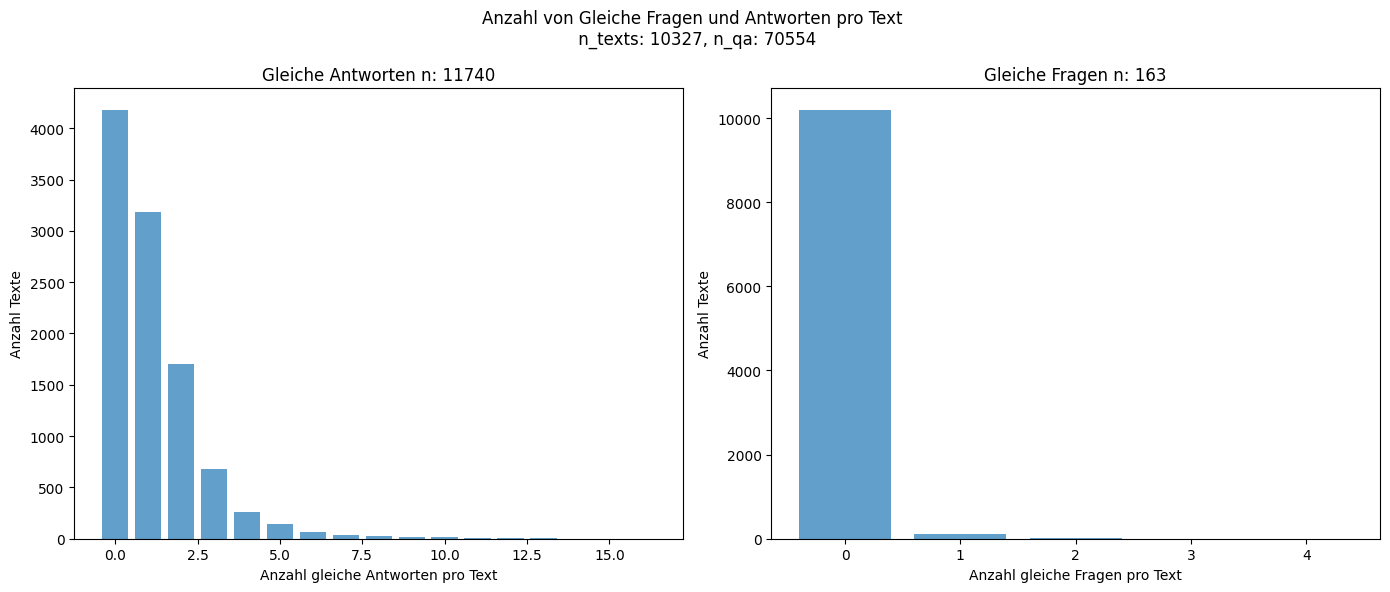

In [11]:
number_of_answers_set = [len(set(answers)) for answers in dataset["train"]["answers"]]
n_duplicates = np.array(number_of_answers) - np.array(number_of_answers_set)

number_counts = Counter(n_duplicates)

unique_numbers = list(number_counts.keys())
counts = list(number_counts.values())

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Adjust the figure size as needed

# Plot for number_of_answers
axs[0].bar(unique_numbers, counts, align='center', alpha=0.7)
axs[0].set_xlabel('Anzahl gleiche Antworten pro Text')
axs[0].set_ylabel('Anzahl Texte')
axs[0].set_title(f'Gleiche Antworten n: {sum(n_duplicates)}')

# Plot for number_of_questions
number_of_questions_set = [len(set(questions)) for questions in dataset["train"]["questions"]]
n_duplicates = np.array(number_of_questions) - np.array(number_of_questions_set)

number_counts = Counter(n_duplicates)

unique_numbers = list(number_counts.keys())
counts = list(number_counts.values())

axs[1].bar(unique_numbers, counts, align='center', alpha=0.7)
axs[1].set_xlabel('Anzahl gleiche Fragen pro Text')
axs[1].set_ylabel('Anzahl Texte')
axs[1].set_title(f'Gleiche Fragen n: {sum(n_duplicates)}')

plt.suptitle(f"Anzahl von Gleiche Fragen und Antworten pro Text \n n_texts: {len(number_of_questions)}, n_qa: {sum(number_of_questions)}")
# Adjust spacing between subplots
plt.tight_layout()
# Display the combined figure with subplots
plt.show()

Es gibt viele Texte mit gleichen Antworten bei unterschiedlichen Fragen. Dies ist plausibel, führt aber dazu, dass nicht völlig unterschiedliche Textabschnitte für jede Frage und Antwort betrachtet werden. Da das Ziel ist Fragen und Antworten für das E-Learning zu generieren, könnte dies zu schlechteren Ergebnissen führen, da es für das E-Learning optimal wäre, wenn nur unterschiedliche Textabschnitte betrachtet werden würden.

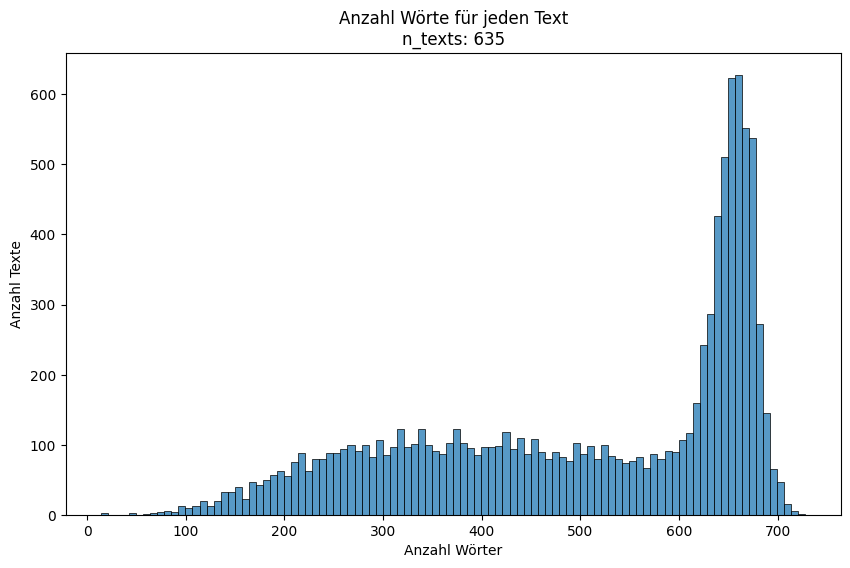

In [12]:
number_counts = Counter([len(answers.split()) for answers in dataset["train"]["paragraph"]])

unique_numbers = list(number_counts.keys())
counts = list(number_counts.values())
data = pd.DataFrame({
    'Anzahl Wörter': unique_numbers,
    'Häufigkeit': counts
})

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data, x='Anzahl Wörter', weights='Häufigkeit', bins=100)
plt.xlabel('Anzahl Wörter')
plt.ylabel('Anzahl Texte')
plt.title(f'Anzahl Wörte für jeden Text\nn_texts: {len(data)}')
plt.show()


Die Länge der Texte sind unterschiedlich und die meisten Texte befinden sich um 650 Wörter.

#### Meist verwendete Wörter

In [13]:
def count_words(data):
    stop_words = set(stopwords.words('english'))
    translator = str.maketrans('', '', string.punctuation)
    word_counts = Counter()

    for paragraph in data:
        words = [word.lower().translate(translator) for word in paragraph.split() if (word.lower().translate(translator) not in stop_words) and len((word.lower().translate(translator))) != 0]
        word_counts.update(words)
    most_common_words = word_counts.most_common(10)
    for word, count in most_common_words:
        print(f"'{word}' occurs {count} times")
    return word_counts

In [14]:
print("Most occured words from the paragraph")
word_counts_paragraph = count_words(dataset["train"]["paragraph"])

Most occured words from the paragraph
'said' occurs 53784 times
'cnn' occurs 15727 times
'people' occurs 12720 times
'one' occurs 12531 times
'new' occurs 9780 times
'us' occurs 9115 times
'would' occurs 9087 times
'two' occurs 8980 times
'also' occurs 8897 times
'told' occurs 7894 times


In [15]:
print("Most occured words from the questions")
word_counts_questions = count_words([item for sublist in dataset["train"]["questions"]for item in sublist])

Most occured words from the questions
'many' occurs 4736 times
'say' occurs 3098 times
'people' occurs 1763 times
'name' occurs 1582 times
'killed' occurs 1096 times
'found' occurs 937 times
'number' occurs 890 times
'new' occurs 876 times
'much' occurs 875 times
'us' occurs 772 times


In [16]:
print("Most occured words from the answers")
word_counts_answers = count_words([item for sublist in dataset["train"]["answers"]for item in sublist])

Most occured words from the answers
'million' occurs 903 times
'two' occurs 890 times
'people' occurs 869 times
'new' occurs 831 times
'us' occurs 704 times
'president' occurs 624 times
'three' occurs 598 times
'one' occurs 567 times
'years' occurs 499 times
'four' occurs 449 times


In den Paragraphtexten kommt regelmässig "cnn" vor und viele allgemeine Wörter wie one, us, also und told. Dies im Gegensatz zu den Fragen und Antworten, wo auch Wörter, wie "killed" und "president" sehr oft vorkommen. Dies macht Sinn, da die Antworten nicht zitieren oder nicht den Namen der Zeitung beinhalten.

#### Verteillung der Wörter

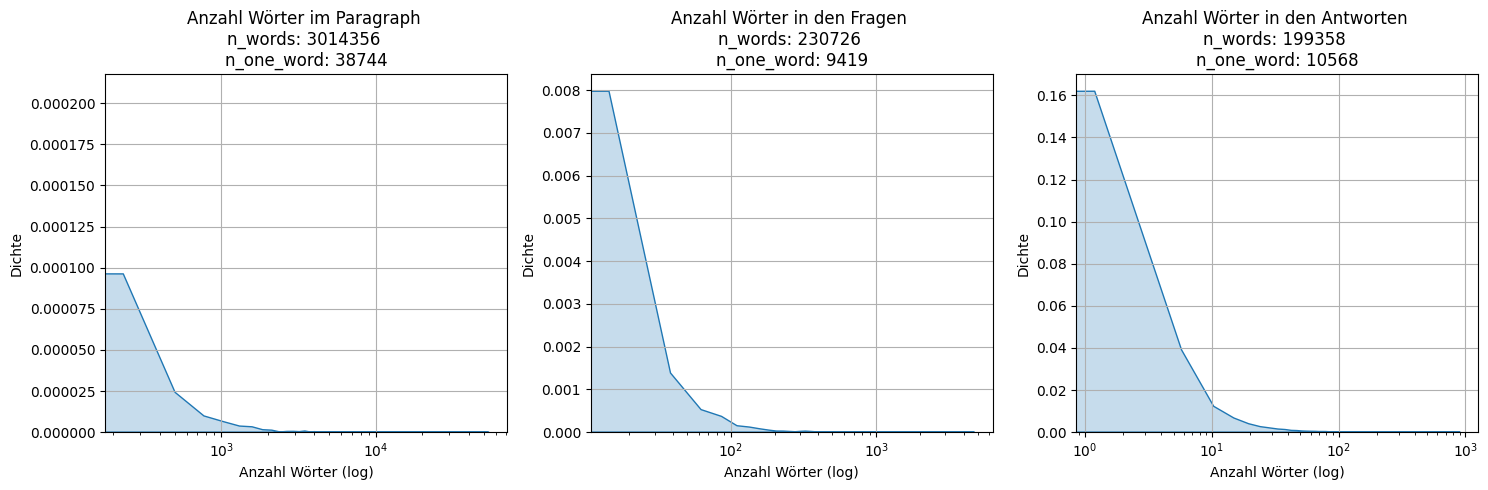

In [17]:
values1 = np.array(list(word_counts_paragraph.values()))
values2 = np.array(list(word_counts_questions.values()))
values3 = np.array(list(word_counts_answers.values()))

plt.figure(figsize=(15, 5))

# First subplot
plt.subplot(1, 3, 1)  
sns.kdeplot(values1, bw_adjust=0.5, fill=True)
plt.xlabel('Anzahl Wörter (log)')
plt.xscale("log")
plt.ylabel('Dichte')
plt.title(f'Anzahl Wörter im Paragraph \nn_words: {sum(values1)} \nn_one_word: {len(values1[values1==1])}')
plt.grid(True)

# Second subplot
plt.subplot(1, 3, 2) 
sns.kdeplot(values2, bw_adjust=0.5, fill=True)
plt.xlabel('Anzahl Wörter (log)')
plt.xscale("log")
plt.ylabel('Dichte')
plt.title(f'Anzahl Wörter in den Fragen \nn_words: {sum(values2)} \nn_one_word: {len(values2[values2==1])}')
plt.grid(True)

# Third subplot
plt.subplot(1, 3, 3) 
sns.kdeplot(values3, bw_adjust=0.5, fill=True)
plt.xscale("log")
plt.xlabel('Anzahl Wörter (log)')
plt.ylabel('Dichte')

plt.title(f'Anzahl Wörter in den Antworten \nn_words: {sum(values3)} \nn_one_word: {len(values3[values3==1])}')
plt.grid(True)

plt.tight_layout()
plt.show()


Die meisten Wörter kommen nur sehr selten vor. Die Testwörter, welche nicht in den bestehenden Embeddings sind, werden vom Modell nicht verstanden. Wenn es auch im Testset viele neue Wörter hat, könnte dies zu schlechten Resultaten führen. 

In [18]:
%%capture
word_counts_paragraph_test = count_words(dataset["validation"]["paragraph"])

In [19]:
words_in_train = word_counts_paragraph.keys()
check = [word in words_in_train for word in word_counts_paragraph_test.keys()]
print(f"{round(np.mean(check),3)*100}% des Validierungswortschatzes kommt auc im Trainingswortschaft vor.")

90.2% des Validierungswortschatzes kommt auc im Trainingswortschaft vor.


Auch die restlichen 10% sollten nicht ein allzu grosses Problem sein, da der SentencePiece Tokenizer, Teile von diesen Wörtern erkennen wird.

## Trainingsprozess

Für das Trainieren des Modells wurde die Package lmqg verwendet, welche vom Repository [asahi417/lm-question-generation](https://github.com/asahi417/lm-question-generation) stammt. Jedoch hatten wir beim Trainingsprozess Probleme mit der Metrik "METEOR", welche eine JAVA Runtime benötigte und somit das Training auf dem I4DS verhinderte. Das hat uns dazu veranlasst, die Package zu forken und zu editieren. Unser Fork ist unter [swiggy123/lm-question-generation](https://github.com/swiggy123/lm-question-generation) zu finden.

Mit der LMQG CLI Schnittstelle konnte das Modell simpel trainiert werden. Wir trainierten das Modell basierend auf den Hyperparametern des ACL 2023 Papers, welche hier zu finden sind: [2023_acl_qag/model_finetuning.end2end.sh](https://github.com/asahi417/lm-question-generation/blob/master/misc/2023_acl_qag/model_finetuning.end2end.sh). Unser Trainingsprozess wurde Beispielweise beim t5-small Modell so gestartet:

```bash
lmqg-train-search -d "StellarMilk/newsqa" -m "t5-small" -b 2 -g 2 4 -c "small_trained_ckpt" -i 'paragraph' -o 'questions_answers' -p 'qag' --epoch-partial 10 -e 15 --max-length-output-eval 512 --max-length-output 512
```

Wobei die Parameter folgendes bedeuten:
|        Parameter         |                                Beschreibung                                 |   Gewählter Wert   |
| :----------------------: | :-------------------------------------------------------------------------: | :----------------: |
|            -d            |              Hugging Face Dataset, das verwendet werden soll.               | StellarMilk/newsqa |
|            -m            |                         Modell, das trainiert wird.                         |      t5-small      |
|            -b            |                                Batchgrösse.                                 |         2          |
|            -g            |                    Schritte für Gradientenakkumulation.                     |      2 oder 4      |
|            -c            |                            Pfad für Checkpoint.                             | small_trained_ckpt |
|            -i            |                         Input-Spalte des Datasets.                          |     paragraph      |
|            -o            |                         Output-Spalte des Datasets.                         | questions_answers  |
|            -p            |                              Modelltyp-Prefix.                              |        qag         |
|     --epoch-partial      |   Anzahl der Epochen, die in der ersten Trainingsphase trainiert werden.    |         10         |
|            -e            | Mindestanzahl der Epochen, die in der zweiten Trainingsphase erreicht wird. |         15         |
| --max-length-output-eval |      Maximale Sequenzlänge für die Ausgabesequenz bei der Evaluation.       |        512         |
|   --max-length-output    |                Maximale Sequenzlänge für die Ausgabesequenz.                |        512         |

Das Modell wird in einem 2-Phasen Hyperparameteroptimierungsprozess trainiert, welche in dieser Grafik dargestellt ist:

<img src="https://raw.githubusercontent.com/asahi417/lm-question-generation/master/assets/grid_search.png" alt="Trainingsprozess" width="800"><br>

In unserem Beispiel werden in der ersten Phase 12 Modelle 10 Epochen trainiert. Danach werden die besten 5 Modelle gewählt und in der zweiten Phase 5 weitere Epochen trainiert (Total 5). Falls das beste Modell bei der Epoche 15 am besten ist, wird dieses Modell weitertrainiert, bis die Validierungsmetrik (standardmässig BLEU-4) nicht mehr besser wird. Falls das beste Modell bei der Epoche 15 nicht am besten ist, wird das Modell mit der besten Metrik gewählt und nicht weitertrainiert.

### Modellliste
Hier eine Liste aller trainierten und/oder evaluierten Modelle:
| Modellname                                    | Beschreibung                                                                               | Evaluationsordner                   | Selbst trainiert? |
| :-------------------------------------------- | :---------------------------------------------------------------------------------------- | :---------------------------------- | :---------------- |
| lmqg/t5-base-squad-qag                        | T5-Baseline Modell, welches auf SQuAD trainiert wurde.                                     | evaluation_base/                    | Nein              |
| StellarMilk/t5-base-newsqa-qag-trained        | T5-Baseline Modell, welches auf NewsQA trainiert wurde.                                    | evaluation_base_trained/            | Ja                |
| lmqg/t5-small-squad-qag                       | T5-Small Modell, welches auf SQuAD trainiert wurde.                                        | evaluation_small/                   | Nein              |
| StellarMilk/t5-small-newsqa-qag-trained       | T5-Small Modell, welches auf NewsQA trainiert wurde.                                       | evaluation_small_trained            | Ja                |
| StellarMilk/t5-small-newsqa-qag-finetuned     | lmqg/t5-small-squad-qag Modell, welches auf NewsQA weitertrainiert wurde.                  | evaluation_small_finetuned          | Ja                |
| `not pushed to HF`                            | lmqg/t5-small-squad-qag Modell, welches auf das modifizierte NewsQA weitertrainiert wurde. | evaluation_small_modified_finetuned | Ja                |
| StellarMilk/t5-small-squad-newsqa-qag-trained | T5-Small Modell, welches auf SQuAD und NewsQA trainiert wurde.                             | evaluation_small_combined_trained   | Ja                |
| StellarMilk/t5-small-squad-qag-recreated      | Recreation des lmqg/t5-small-squad-qag Modells                                             | evaluation_small_recreated          | Ja                |

## Losskurven

Während des Trainings wird auf eine Kreuzvalidierung verzichtet, da wir die Rechenkapazitäten des Slurm Cluster nicht überstrapazieren möchten. Um Fehler abschätzen zu können, wäre dies Sinnvoll. Ganz im Allgemeinen ist das Logging des verwendeten Repository nicht optimal. Dies müsste in einem weiteren Schritt angepasst werden, um genauere Aussagen zu treffen. Der Validierungsloss wird zum Beispiel nicht gespeichert. Zudem werden nur der Trainingsloss abgespeichert bis zur Epoche des besten Validierungsbleu-4 Score.

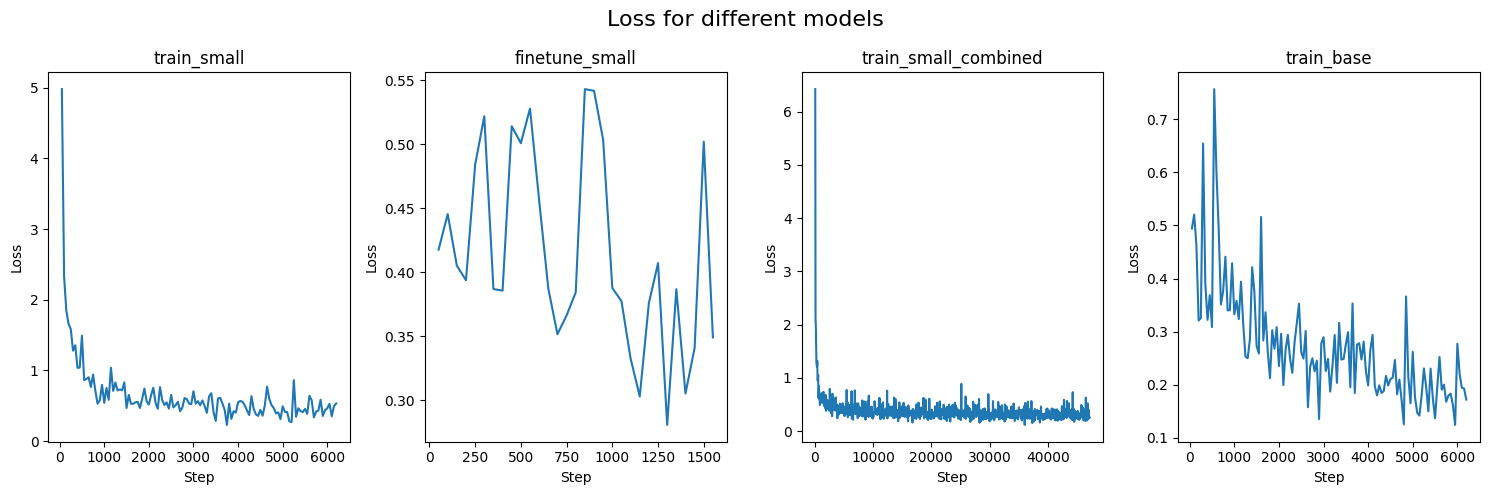

In [20]:
evaluation_folder = ["train_small",
          "finetune_small",
          "train_small_combined","train_base"]

folders_ckpt_dir = [
    "small_trained",
    "small_finetuned",
    "small_combined_trained","base_trained"]
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Loss for different models', fontsize=16)
for i in range(len(folders_ckpt_dir)):
    log_file_path = f"./slurm/logs/{evaluation_folder[i]}_err.txt"
    ckpt_dir = folders_ckpt_dir[i]
    name = utils.get_best_model(log_file_path, ckpt_dir=ckpt_dir)
    df, average_loss = utils.get_loss(log_file_path, name)
    sns.lineplot(df,x="Step",y="Loss",ax=axes[i])
    axes[i].set_title(evaluation_folder[i])
plt.tight_layout()
plt.show()

Die kleinen Modelle (train_small,finetune_small und train_small_combined) konvergieren bei einer Trainingsloss von ungefähr 0.4. Dabei kann mit finetunen nicht bessere Resultate erzielt werden, darum werden die Resultate nach einer Epoche ausgegeben. Das bedeutet, dass die Transferierbarkeit der Squad-Daten auf die Newsqa Daten möglich ist. Das Base Modell konvergiert bei einem Trainingsloss bei etwa 0.2.

## Erroranalyse

In diesem Kapitel analysieren wir drei Fehler, welche das Modell small-fine-tuned macht. Wir untersuchen den Output, identifizieren die Fehler und schlagen mögliche Lösungen vor. Im nächsten Kapitel werden gewisse Lösungen implementiert und die Resultate neu evaluiert.

In [21]:
folders = [
    "evaluation_small",
    "evaluation_small_trained",
    "evaluation_small_finetuned",
    "evaluation_small_combined_trained",
    "evaluation_small_trained",
]
def load_evaluation_data(folders):
    df_list = []
    for folder in folders:
        df = pd.read_json(f"./{folder}/metric.first.answer.paragraph.questions_answers.StellarMilk_newsqa.default.json")
        df["Model"] = folder[11:]
        df_list.append(df)
        
    df = pd.concat(df_list)
    df = df.reset_index(names=["Metric"])
    df = df.melt(id_vars=["Metric","Model"],var_name="Dataset",value_name="Value")
    return df

df = load_evaluation_data(folders)

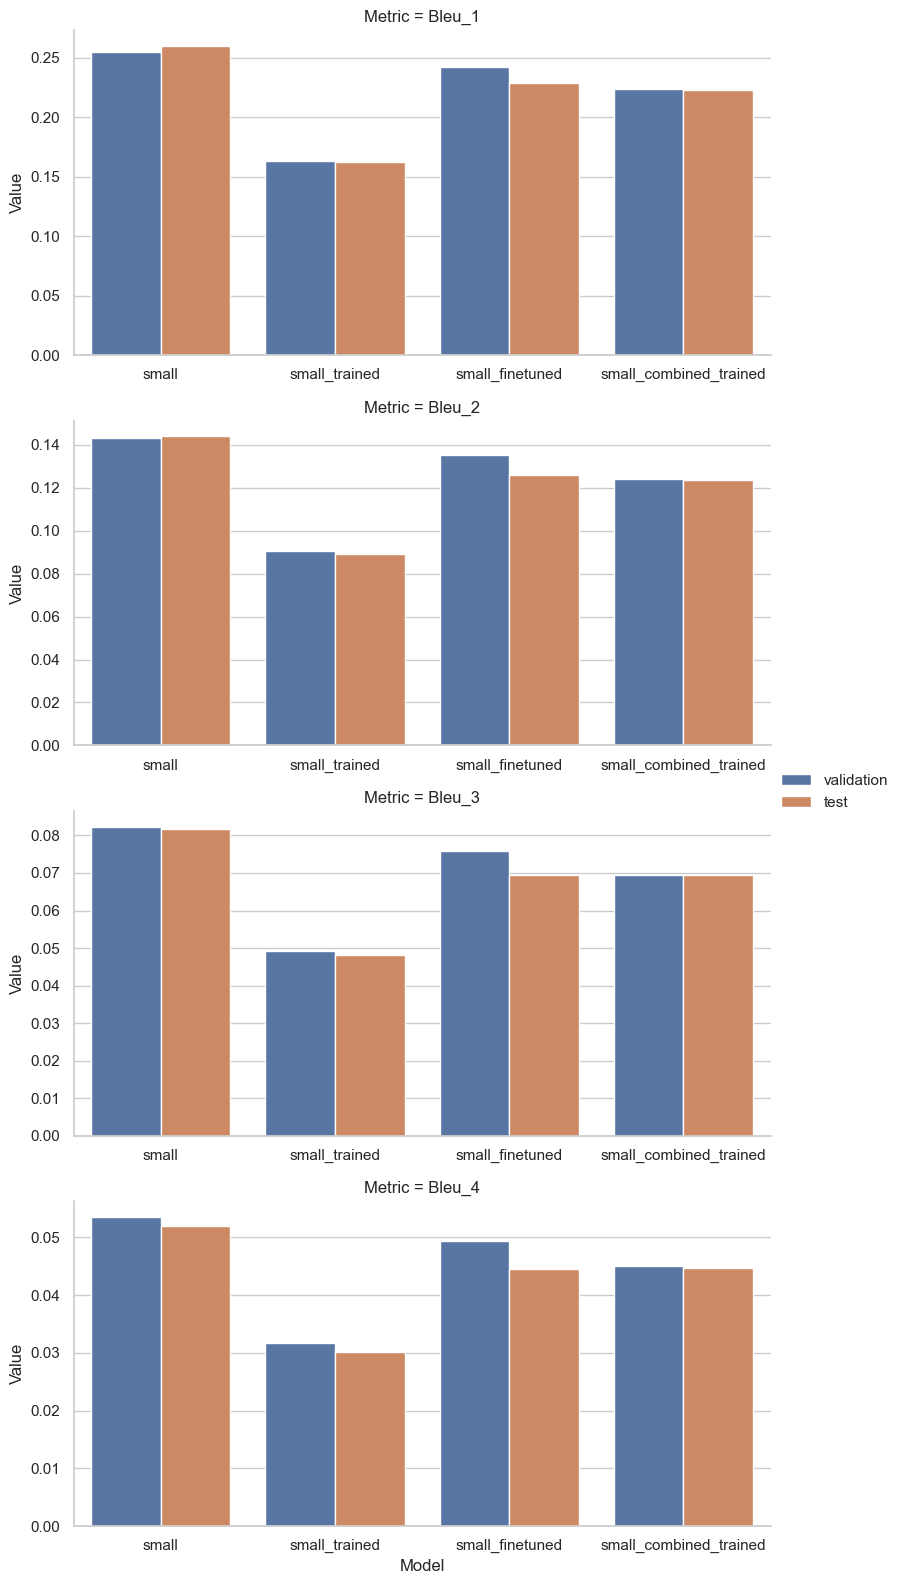

In [22]:
def plot_results(df):
    sns.set_theme(style="whitegrid")
    g = sns.FacetGrid(df, row="Metric", height=4, aspect=2, sharex=False, sharey=False)
    g.map(sns.barplot, "Model", "Value", "Dataset", palette="deep", order=["small","small_trained","small_finetuned","small_combined_trained","small_trained"], hue_order=["validation","test"])
    g.add_legend()

plot_results(df[df["Metric"].str.contains("Bleu")])

Das Baseline-Modell "small" erzielt durchgehend die besten BLEU-Scores auf beiden Datensätzen. Im Gegensatz dazu steht das Modell "small_trained", welches konsistent niedrigere Scores im Vergleich zu den anderen Modellen aufweist. Dies könnte auf ein Overfitting während des Trainingsprozesses oder auf einen Mangel an Generalisierungsfähigkeit hinweisen. 

Das Modell "small_finetuned" sticht als leistungsstärkstes Modell hervor. Dieses Modell erzielt aber konsequent höhere BLEU-Scores im Validierungsdatensatz als im Testdatensatz. Das ist auf das Hyperparameter-tuning und die Modell-Selektion zurückzuführen, die die library auf dem Validation-Datensatz macht. Dieser Effekt ist beim Modell small_trained auch zu beobachten aber beim small_combined_trained fast nicht. Allerdings ist das Modell small_combined_trained minimal schlechter als small_finetuned.

Zusammengefasst: Wenn man nur den BLEU-Score 1-4 betrachtet, lohnt es sich nicht das Modell selber zu trainieren. Die besten Ergebnisse erzielen wir mit dem Basismodell, dass wir nicht selber trainiert haben.

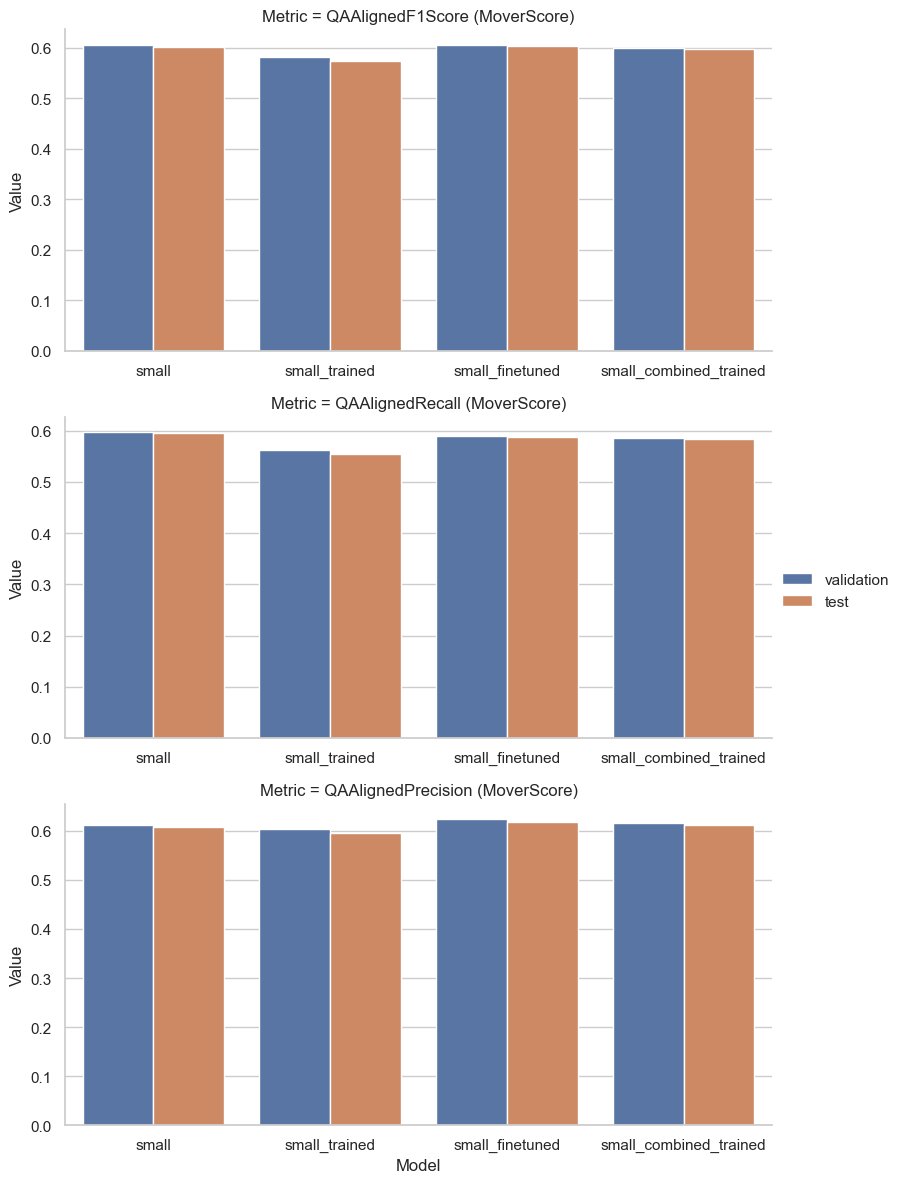

In [23]:
plot_results(df[df["Metric"].str.contains("(MoverScore)", regex=False)])

Der QAAligned-Score (MoverScore) ist bei allen Modellen etwa gleich gut. Die trainierten Modelle schneiden immer ein bisschen schlechter ab. Ausser bei der QAAlignedPrecision. Dort sind die Modell esmall_finetuned und small_combined_trained ein bisschne besser als das small. Generell hat das small_finetuned Modell die besten Ergebnisse der selbst trainierten Modelle.

### Qualitative Evaluation
Wir evaluiren jeweils nur das beste Modell (small_finetuned) und vergleiche es wenn nötig mit dem baseline Modell.

In [24]:
dataset = load_dataset("StellarMilk/newsqa")

In [25]:
dataset["test"][0]["paragraph"]

'WASHINGTON (CNN) -- President Obama urged Congress to adopt a "pay-as-you-go" approach to federal spending in order to restore fiscal discipline, but critics say the president\'s call lacks credibility.\n\n\n\nPreisdent Obama says PAYGO is common sense.\n\n\n\nFaced with a record $1.8 trillion deficit, Obama on Tuesday pushed Congress to take up the spending rules, known as PAYGO. The approach would require lawmakers to pay for new programs, dollar-for-dollar, with budget cuts elsewhere.\n\n\n\n"The \'pay as you go\' rule is very simple. Congress can only spend a dollar if it saves a dollar elsewhere," Obama said, as he announced that he was submitting to Congress a proposal to make PAYGO law.\n\n\n\nObama repeated his vow to halve the deficit by the end of his first term, and he said PAYGO is an important step toward making that happen. A previous PAYGO mandate helped erase federal budget deficits in the 1990s, and subsequent ineffective rules contributed to the current budget defici

In [26]:
def load_paragraphs(path):
    """
    Load paragraphs from a file and return a list of paragraphs. Each paragraph is a list of dictionaries with keys "Question" and "Answer".
    """
    paragraphs = []
    with open(path, "r", encoding="UTF-8") as file:
        for line in file:
            paragraphs.append(line)
            
    parsed_paragraphs = []
    failed_paragraphs = []
    for paragraph in paragraphs:
        q_and_as = []
        failed = False
        for q_and_a in paragraph.split(" | "):
            try:
                q_and_as.append({
                    "Question": q_and_a.split(", answer:")[0].split("question: ")[1].strip(),
                    "Answer": q_and_a.split(", answer:")[1].strip()
                })
            except IndexError:
                failed = True
                break
        parsed_paragraphs.append(q_and_as)
        failed_paragraphs.append(paragraph if failed else None)
    return parsed_paragraphs, failed_paragraphs


fine_tuned_paragraphs, fine_tuned_failed = load_paragraphs("./evaluation_small_finetuned/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")
trained_paragraphs, trained_failed = load_paragraphs("./evaluation_small_trained/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")
trained_combined_paragraphs, trained_combined_failed = load_paragraphs("./evaluation_small_combined_trained/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")
baseline_paragraphs, baseline_failed = load_paragraphs("./evaluation_small/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")

#### 1. Error: Wiederholung von gleichen Fragen

In [27]:
def print_paragraph(i, baseline_paragraphs=baseline_paragraphs, trained_paragraphs=fine_tuned_paragraphs):
    print("Paragraph context:")
    print(dataset["test"][i]["paragraph"].replace("\n\n", "\n").replace("\n\n", "\n"))
    print("------------------")
    print("\nGround truth answers:")
    for question, answer in zip(dataset["test"][i]["questions"], dataset["test"][i]["answers"]):
        print(question)
        print(answer)
        print("------------------")
    print("\nBaseline model answers:")
    for q_and_a in baseline_paragraphs[i]:
        print(q_and_a["Question"])
        print(q_and_a["Answer"])
        print("------------------")
    print("\nFine tuned/trained model answers:")
    for q_and_a in trained_paragraphs[i]:
        print(q_and_a["Question"])
        print(q_and_a["Answer"])
        print("------------------")

print_paragraph(0)

Paragraph context:
WASHINGTON (CNN) -- President Obama urged Congress to adopt a "pay-as-you-go" approach to federal spending in order to restore fiscal discipline, but critics say the president's call lacks credibility.
Preisdent Obama says PAYGO is common sense.
Faced with a record $1.8 trillion deficit, Obama on Tuesday pushed Congress to take up the spending rules, known as PAYGO. The approach would require lawmakers to pay for new programs, dollar-for-dollar, with budget cuts elsewhere.
"The 'pay as you go' rule is very simple. Congress can only spend a dollar if it saves a dollar elsewhere," Obama said, as he announced that he was submitting to Congress a proposal to make PAYGO law.
Obama repeated his vow to halve the deficit by the end of his first term, and he said PAYGO is an important step toward making that happen. A previous PAYGO mandate helped erase federal budget deficits in the 1990s, and subsequent ineffective rules contributed to the current budget deficits, Obama sai

Wir haben festgestellt, dass das Baseline-Modell in der Lage ist, verschiedene Fragen und Antworten zu bearbeiten. Nebenbei haben wir noch bemerkt, dass die erste Frage und Antwort wenig Sinn ergeben: "Do Democrats feel "pay-as-you-go" is responsible? and necessary.". Das könnte darauf zurück zuführen sein, dass politischen Themen in Amerika sehr polarisierend sind (und dann die Antworten an Qualität verlieren). Das könnte man aber beheben, indem man den Datensatz bereinigt (entweder von Hand oder mit z.B. ChatGPT).

Beim fine-tuned Modell haben wir ein anderes Problem beobachtet: Nach der zweiten Frage kommt es zu Wiederholungen. Die Frage und Antwort wird einfach drei Mal wiederholt. Dennoch ist die gestellte Frage korrekt und kommt fast identisch in den Testdaten vor.

Um diese Probleme zu lösen, könnten wir verschiedene Ansätze verfolgen. Ein Vorschlag ist es eine Frequenzstrafe (frequency penalty) zu setzen. Damit werden weniger häufige Wörter bevorzugt beim Generieren. Auch mit der Temperatur könnte man das Modell dazu bringen, mehr Abwechslung zu generieren.

Ein weiterer Ansatz wird in der Studie [Learning to Break the Loop: Analyzing and Mitigating Repetitions for Neural Text Generation](https://arxiv.org/pdf/2206.02369v1.pdf) beschrieben. Die Autoren stellen fest, dass Sprachmodelle dazu neigen, den vorherigen Satz zu wiederholen. Diese Satzwiederholungen verstärken sich selbst: Je öfter ein Satz im Kontext wiederholt wird, desto wahrscheinlicher wird es, diesen Satz weiterhin zu generieren. Insbesondere Sätze mit anfänglich höheren Wahrscheinlichkeiten neigen zu einem stärkeren Selbstverstärkungseffekt. Basierend auf diesen Erkenntnissen schlagen die Autoren eine einfache und effektive Trainingsmethode vor, die als DITTO (PseuDo-RepetITion PenalizaTiOn) bezeichnet wird. Dabei lernt das Modell, Wahrscheinlichkeiten von Satzwiederholungen durch Pseudo-Wiederholungsdaten während dem Training zu bestrafen.

Noch ein weiterer Ansatz könnte Self-Reflection sein. Dabei evaluiert das Modell die generierten Fragen und Antworten und versucht, diese zu verbessern.

#### 2. Error: Fragen und Antworten können nicht geparsed werden

In [28]:
failed_indices = []
for i, fine_tuned in enumerate(fine_tuned_failed):
    if fine_tuned:
        failed_indices.append(i)
        print(fine_tuned)
print(failed_indices)

question: What is a combustible combo that explodes into headlines when an ex-president lights the fuse, as Jimmy Carter did recently?, answer: Race and politics | question: What is a combustible combo that explodes into headlines when an ex-president lights the fuse, as Jimmy Carter did recently. | question: What is a combustible combo that explodes into headlines when an ex-president lights the fuse, as Jimmy Carter did recently. | question: What is a combustible combo that explodes into headlines?, answer: "When a radical fringe element of demonstrators and others begin to attack the president of the United States as an animal or as a reincarnation of Adolf Hitler or when they wave signs in the air that said we should have buried Obama with Kennedy, those kinds of things are beyond the bounds,"?, answer: "when a radical fringe element of demonstrators and others begin to attack the president of the United States as a reincarnation of Adolf Hitler or when they wave signs in the air t

In [29]:
random.seed(42)
failed_indices = random.sample(failed_indices, 5)
for i in failed_indices:
    print(f"Failed example {i}:")
    print(fine_tuned_failed[i].replace(" | ", "\n"))

Failed example 453:
question: What did the Democratic-controlled Senate reject?, answer: two proposed versions for a balanced budget amendment to the Constitution
question: What did the Republican-controlled House of Representatives fail to pass?, answer: a GOP-proposed amendment,
question: What did the Republican-controlled House of Representatives fail to pass?, answer: a GOP-proposed amendment,
question: What did the Republican-controlled House of Representatives fail to pass?, answer: a GOP-proposed amendment,
question: What percentage of Americans believe a balanced budget amendment is necessary to get the deficit under control, according to the poll.

Failed example 81:
question: Who voted to ban future "unreasonable and excessive" compensation at companies receiving federal bailout money?, answer: The House of Representatives
question: Who voted to ban future "unreasonable and excessive" compensation at companies receiving federal bailout money?, answer: The House of Representat

Unser fine-tuned Modell generiert nicht immer valide Outputs (im Sinne des Formates). Manchmal (Beispiele 1, 2 und 4) generiert das Modell am Schluss keine Antwort mehr. Bei den anderen beiden Beispielen (3 und 5) generiert das Modell die Frage und wiedrholt sie nochmals als Frage bis es die Antwort darauf generiert. Auffällig ist bei allen Beispielen, dass die Frage mit einem Punkt statt einem Fragezeichen endet.

In [30]:
total_questions = 0
question_endings = {}
for paragraph in dataset["train"]:
    for question in paragraph["questions"]:
        ending = question[-1]
        if ending in question_endings:
            question_endings[ending] += 1
        else:
            question_endings[ending] = 1
        total_questions += 1


sorted_question_endings = sorted(question_endings.items(), key=lambda x: x[1], reverse=True)
print("Top 10 question endings by frequency:")
print(sorted_question_endings[:10])
print(total_questions)

Top 10 question endings by frequency:
[('?', 62715), ('e', 1088), ('d', 1078), ('s', 861), ('y', 710), ('t', 649), ('n', 643), ('r', 534), ('o', 332), ('g', 314)]
70554


Auffällig ist, das etwa ein neuntel der Fragen gar nicht mit einem Fragezeichen aufhört.

In [31]:
for paragraph in baseline_failed:
    if paragraph:
        print(paragraph.replace(" | ", "\n"))

print(f"Number of failed paragraphs in fine tuned model: {sum(1 for paragraph in fine_tuned_failed if paragraph)}")
print(f"Number of failed paragraphs in trained model: {sum(1 for paragraph in trained_failed if paragraph)}")
print(f"Number of failed paragraphs in trained combined model: {sum(1 for paragraph in trained_combined_failed if paragraph)}")

question: What does the Americans with Disabilities Act apply to?, answer: hiring and firing decisions involving "ministerial employees" like teachers who may have primarily secular job duties
question: What did the justices appear at odds over?, answer: whether this is substantive discrimination or simple retaliation against a Michigan teacher
question: What was Cheryl Perich fired for?, answer: insubordination and "regrettable" conduct toward church leaders
question: What was Cheryl Perich fired for

question: What is Valerie Jarrett's name?, answer: Senior Adviser and Assistant to the President for Intergovernmental Affairs and Public Liaison
question: When did Jarrett interview his fiancée, Michelle Robinson, for a job in Chicago Mayor Richard Daley's office
question: When did Jarrett interview his fiancée, Michelle Robinson, for a job in Chicago Mayor Richard Daley's office?, answer: 1991
question: When did Jarrett interview his fiancée?, answer: May 2008

question: According to t

Das Baseline-Modell performt wesentlich besser. Es gibt gesamthaft nur 3 Outputs die nicht geparsed werden konnten. Beim fine-tuned sind es 48 outputs, beim trained 182 und beim combined_trained 81.

Das Problem scheint dadurch zu entstehen, dass viele Trainingsfragen gar nicht mit einem Fragezeichen aufhören und gleichzeitig, hält das Modell wahrscheinlich sehr stark daran fest, dass erst nach einem Fragezeichen die Zeichefolge ", answer: " folgen darf.

Das Problem könnte man beheben indem man a) die Fragen löscht, die nicht mit einem Fragezeichen enden oder b) die Lossfunktion so erweitert, dass sie das Modell bestraft, wenn es nach einer Frage mit dem " | " Zeichen weiterfahren will ohne eine Antwort zu generieren.

#### 3. Error: Falsche Antwort

In [32]:
print_paragraph(2)

Paragraph context:
WASHINGTON (CNN) -- President Obama will deliver a speech June 4 in Egypt on America's relationship with the Muslim world, White House Press Secretary Robert Gibbs announced Friday.
President Obama will travel to Egypt next month to address U.S. relations with the Muslim world.
Egypt is "a country that in many ways represents the heart of the Arab world," Gibbs said.
He deflected several questions at his daily briefing about whether Egypt is a wise choice, given President Hosni Mubarak's resistance to making his government more democratic.
Obama originally promised to deliver the speech during his first 100 days, but senior administration officials say the date slipped in part because of security and logistical issues.
The officials stressed, however, that the Secret Service still has deep security concerns, given the continued tumult in the Mideast.
Obama chose Turkey, a more secular state, as the site of his first presidential speech to a Muslim majority nation, on

Die letzte Frage, die das Modell beantworten sollte, wurde falsch beantwortet, obwohl die korrekte Antwort im Text vorhanden war und von dem Modell in ähnlichen Fragen zuvor richtig identifiziert wurde. Dies zeigt eine Inkonsistenz in der Leistung des Modells. Interessanterweise zeigen sowohl das Baseline- als auch das fine-tuned Modell ähnliche Fehler. Besonders auffällig ist der Fehler, bei dem Deutschland als "Muslim majority nation" bezeichnet wird, was offensichtlich unzutreffend ist.

Diese Fehler könnten darauf hindeuten, dass Large Language Models (LLMs) zwar statistische Zusammenhänge zwischen Wörtern erkennen, aber nicht notwendigerweise deren tatsächliche Bedeutung im Kontext verstehen. Das Modell scheint hier eher nach einem Prinzip zu arbeiten, bei dem es erwartet, dass an bestimmter Stelle ein Land oder eine Person genannt werden muss, ohne den Gesamtzusammenhang vollständig zu erfassen.

Der einzige scheinbare Weg, diese Art von Fehlern zu beheben, wäre die Entwicklung von noch intelligenteren und grösseren Modellen mit mehr Parametern. Dies würde es den Modellen ermöglichen, mehr Allgemeinwissen zu haben (das eine Spokesperson nicht in andere Länder reist), komplexere Kontexte zu verstehen und somit präzisere und konsistentere Antworten zu liefern.

## Verbesserungvorschläge und dazugehörige Evaluation

In diesem Kapitel führen wir zwei Verbesserungsvorschläge durch und evaluieren diese. Die Verbesserungsvorschläge sind 1) die Verwendung von einem grösseren Modell (base statt small) und b) die Verwendung vom Datensatz nur mit Fragen, die mit einem Fragezeichen enden (small_modified_finetuned).

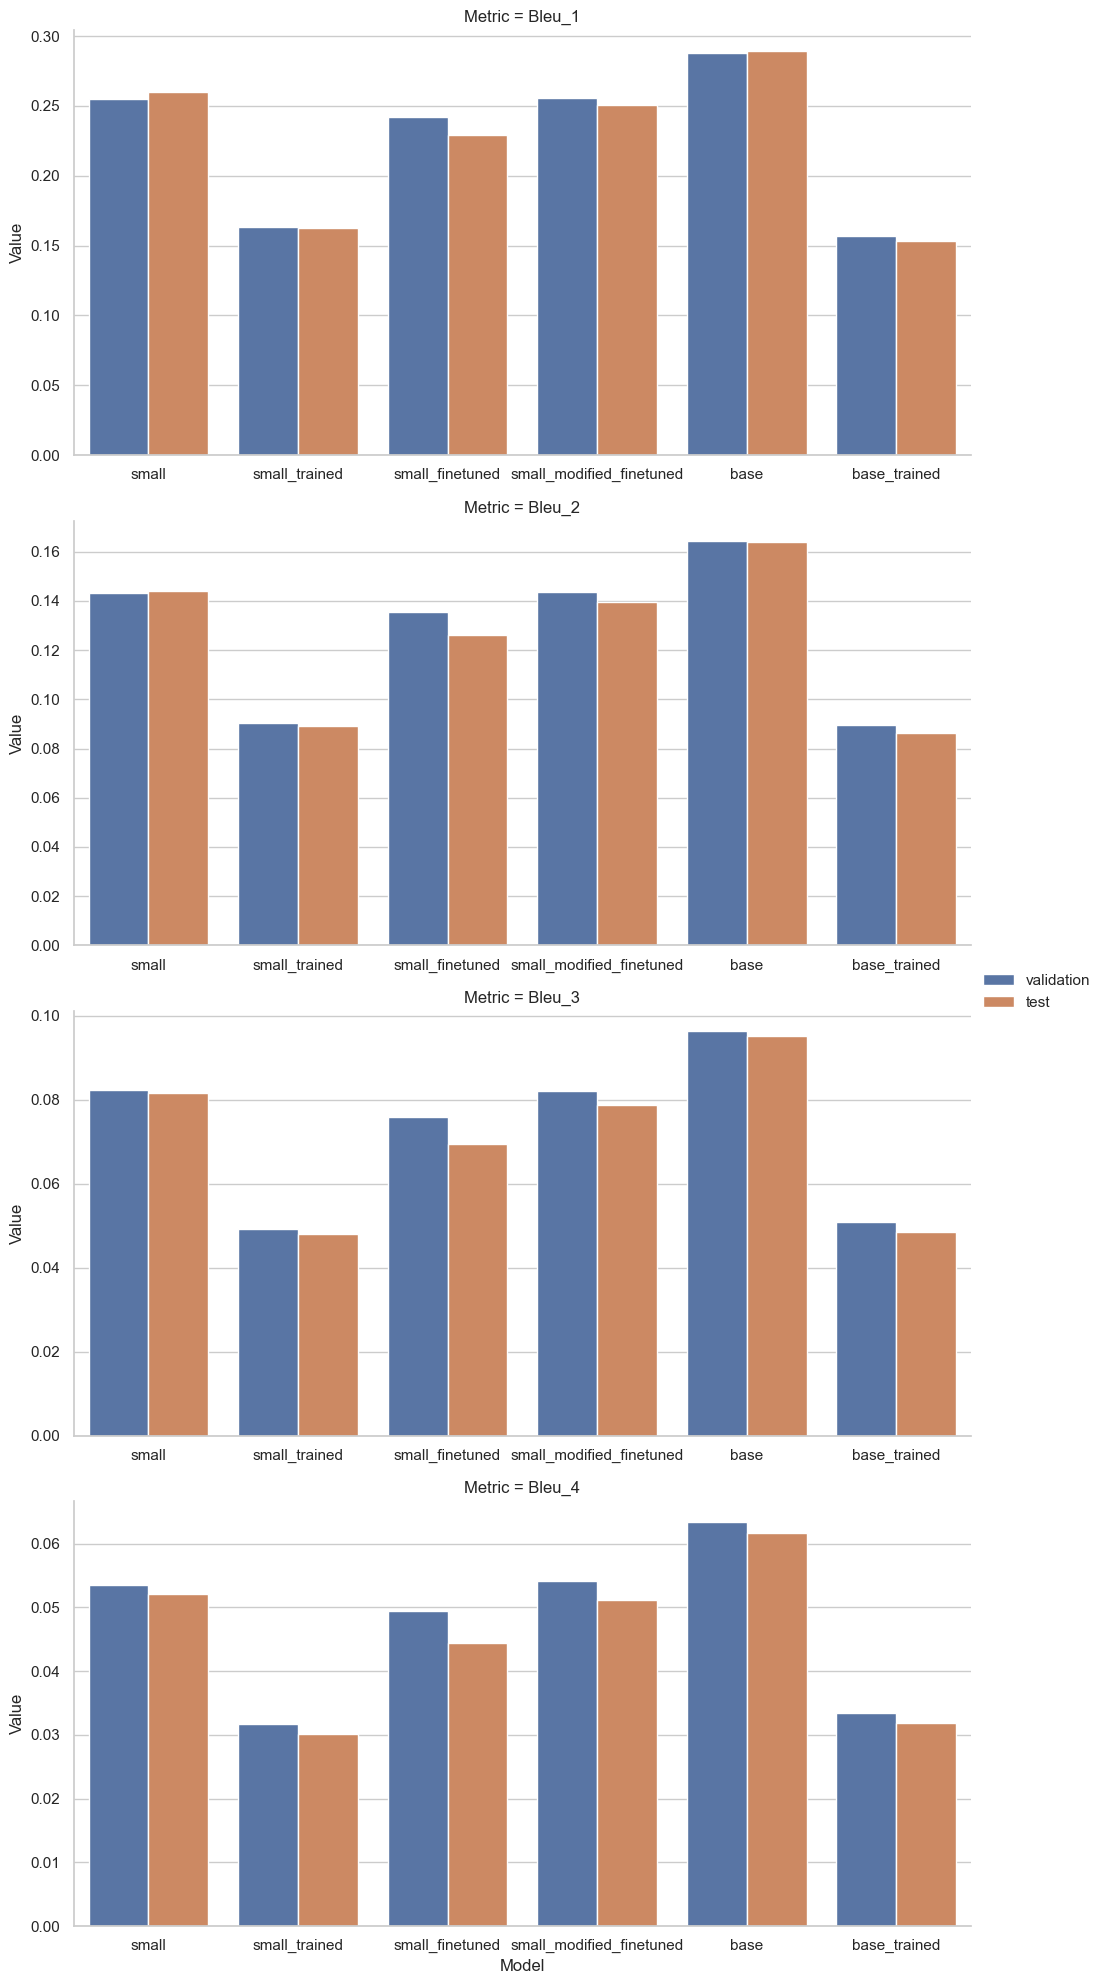

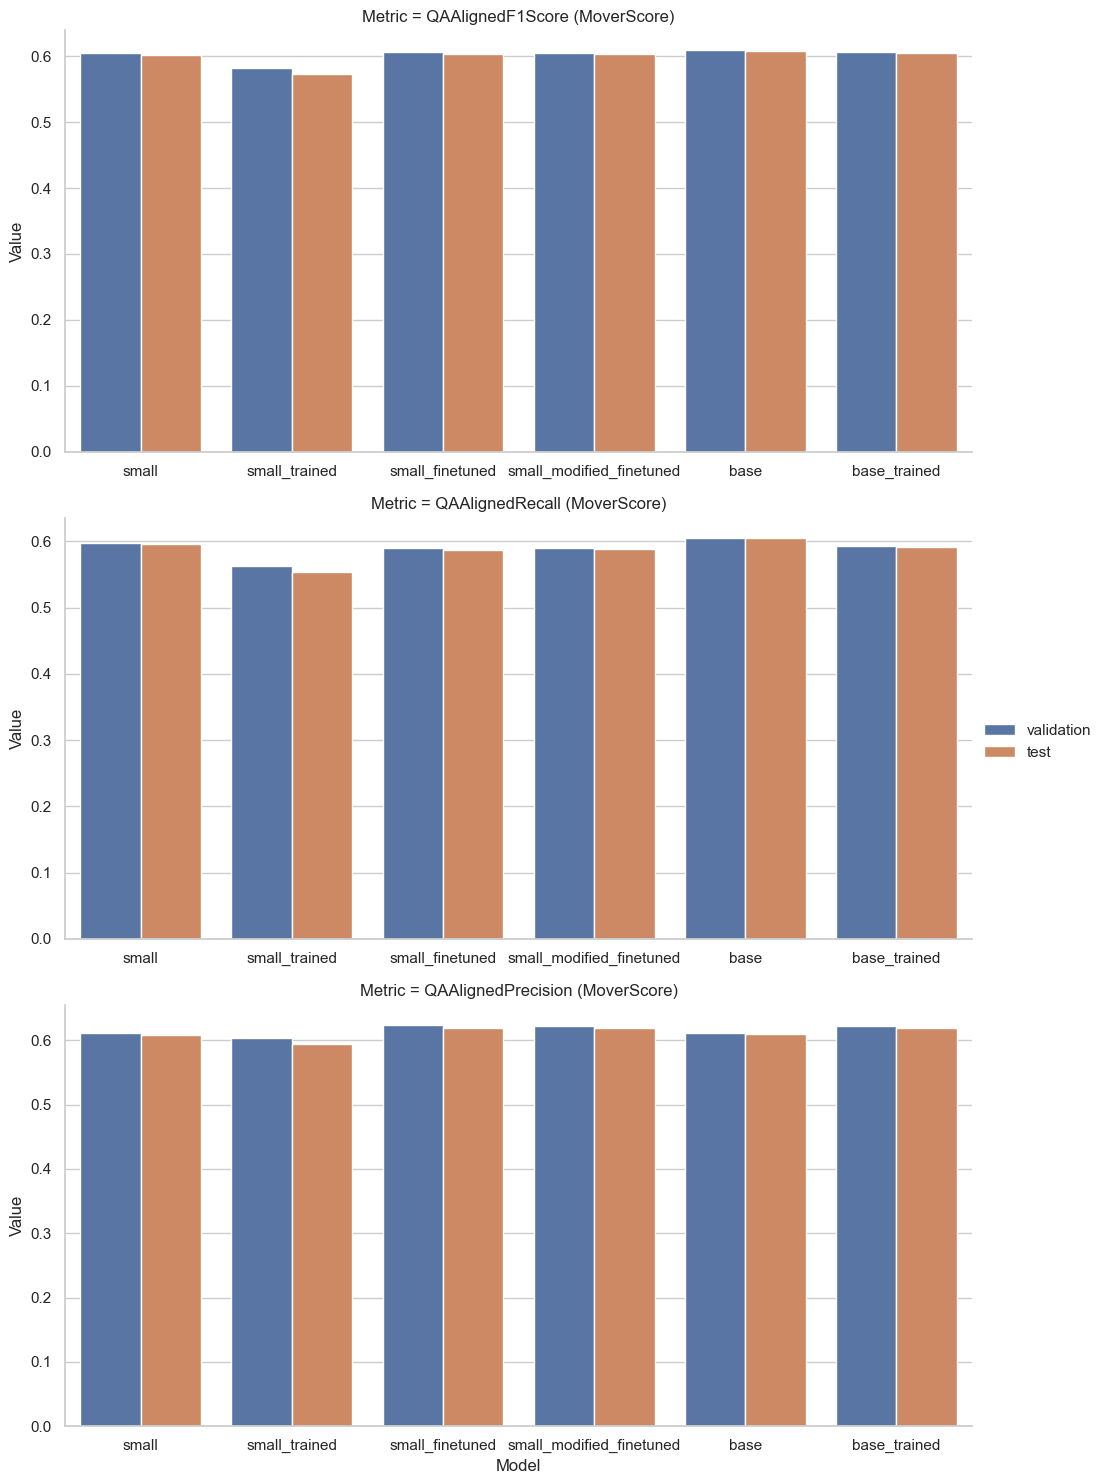

In [43]:

bigger_folders = [
    "evaluation_base",
    "evaluation_base_trained",
    "evaluation_small",
    "evaluation_small_trained",
    "evaluation_small_finetuned",
    "evaluation_small_modified_finetuned"
]

df_bigger = load_evaluation_data(bigger_folders)

def plot_results_bigger(df_bigger):
    sns.set_theme(style="whitegrid")
    g = sns.FacetGrid(df_bigger, row="Metric", height=5, aspect=2, sharex=False, sharey=False)
    g.map(sns.barplot, "Model", "Value", "Dataset", palette="deep", order=["small", "small_trained", "small_finetuned", "small_modified_finetuned", "base","base_trained"], hue_order=["validation","test"])
    g.add_legend()

plot_results_bigger(df_bigger[df_bigger["Metric"].str.contains("Bleu")])
plot_results_bigger(df_bigger[df_bigger["Metric"].str.contains("(MoverScore)", regex=False)])

Der BLEU-Score des small_modified_finetuned ist etwa gleich gut wie das small Modell, trozt mehr Parameter. Aber dennoch besser als das small_finetuned, was gut aussieht.

Das base_trained schneidet gleich gut wie das small_trained ab. Das sieht nicht so gut aus. Allerdings ist das base Modell deutlich besser als das small Modell.

Beim QAAlignedScore sind wiederum alle Modelle etwa gleich gut.

In [44]:
baseline_big_paragraphs, baseline_big_failed = load_paragraphs("./evaluation_base/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")
trained_big_paragraphs, trained_big_failed = load_paragraphs("./evaluation_base_trained/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")
small_modified_finetuned_paragraphs, small_modified_finetuned_failed = load_paragraphs("./evaluation_small_modified_finetuned/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")

### Grösseres Modell

Ein Vorschlag war es, ein grösseres Modell mit mehr Parametern zu verwenden um das Verständnis des Modells zu verbessern. Dazu haben wir das Base-Modell verwendet. Dies hat 220 Millionen Parameter, während das Small-Modell nur 60 Millionen Parameter hat (siehe Beschreibung oben).

Wir wollten nicht von Anfang an das Base-Modell verwenden, weil das Training 5-Tage dauerte und auf dem Small-Modell aber nur 18 Stunden.

In [35]:
print_paragraph(2, baseline_paragraphs=baseline_big_paragraphs, trained_paragraphs=trained_big_paragraphs)

Paragraph context:
WASHINGTON (CNN) -- President Obama will deliver a speech June 4 in Egypt on America's relationship with the Muslim world, White House Press Secretary Robert Gibbs announced Friday.
President Obama will travel to Egypt next month to address U.S. relations with the Muslim world.
Egypt is "a country that in many ways represents the heart of the Arab world," Gibbs said.
He deflected several questions at his daily briefing about whether Egypt is a wise choice, given President Hosni Mubarak's resistance to making his government more democratic.
Obama originally promised to deliver the speech during his first 100 days, but senior administration officials say the date slipped in part because of security and logistical issues.
The officials stressed, however, that the Secret Service still has deep security concerns, given the continued tumult in the Mideast.
Obama chose Turkey, a more secular state, as the site of his first presidential speech to a Muslim majority nation, on

Jetzt haben wir zwar neue Fragen und Antworten. Allerdings ist die Antwort `is "a country that in many ways represents the heart of the Arab world,"` auf die Frage `What did Obama say about Egypt?` falsch (das hat Gibbs gesagt), wir konnten das Problem leider nicht ganz lösen. Eine Evaluation um wie viel wir das Problem verbessern konnten wäre Zeitaufwändig (alles manuell evaluieren) oder teuer (mit einem anderen Modell evaluieren).

### fine tuned mit nur Fragen mit Fragezeichen

Ein weiterer Verbesserungsvorschlag war die Verwendung von einem Datensatz, der nur Fragen mit Fragezeichen enthält. Dazu haben wir den Datensatz bereinigt und hier hochgeladen: [https://huggingface.co/datasets/StellarMilk/newsqa_modified](https://huggingface.co/datasets/StellarMilk/newsqa_modified).



In [45]:
print(f"Number of failed paragraphs in base model: {sum(1 for paragraph in baseline_big_failed if paragraph)}")
print(f"Number of failed paragraphs in trained base model: {sum(1 for paragraph in trained_big_failed if paragraph)}")
print(f"Number of failed paragraphs in modified finetuned small model: {sum(1 for paragraph in small_modified_finetuned_failed if paragraph)}")

Number of failed paragraphs in base model: 3
Number of failed paragraphs in trained base model: 45
Number of failed paragraphs in modified finetuned small model: 24


Beim Basismodell wurden wieder drei Paragraphen nicht geparsed. Beim trained_base Modell sind es 45 Paragraphen die fehlschlugen. Das ist etwa ein viertel im Vergleich zum small_trained. Das modified finetuned small Modell hat nur noch bei 24 Paragraphen Fehler. Das ist ein drittel bis ein viertel im Vergleich zum small_finetuned.

Somit hat die Bereinigung des Datensatz einen positiven Effekt auf die Qualität der generierten Fragen und Antworten. Unklar ist aber, ob es daran liegt, dass die Fragen mit Fragezeichen besser sind oder ob weniger Daten beim fine-tuning zu besseren Ergebnissen führen. Deshalb haben wir noch zufällig 5 Fehler qualitativ evaluiert.

In [46]:
random.seed(420)
failed_indices = random.sample(failed_indices, 5)
for i in failed_indices:
    print(f"Failed example {i}:")
    print(fine_tuned_failed[i].replace(" | ", "\n"))

Failed example 453:
question: What did the Democratic-controlled Senate reject?, answer: two proposed versions for a balanced budget amendment to the Constitution
question: What did the Republican-controlled House of Representatives fail to pass?, answer: a GOP-proposed amendment,
question: What did the Republican-controlled House of Representatives fail to pass?, answer: a GOP-proposed amendment,
question: What did the Republican-controlled House of Representatives fail to pass?, answer: a GOP-proposed amendment,
question: What percentage of Americans believe a balanced budget amendment is necessary to get the deficit under control, according to the poll.

Failed example 16:
question: What did Republicans say could lead to?, answer: a "meltdown" of the government's health care system for the elderly.
question: Who called several Republicans trying to persuade them to support a bill that would reverse a 10.6 percent cut in Medicare payments to doctors.
question: Who called several Repu

Die Art der Fehler ist immernoch gleich wie beim small_finetuned Modell (siehe oben).

## Weitere Ideen

Zusammengefasst, haben wir folgende Verbesserungsvorschläge und Ideen:

1. **Datensatzbereinigung:** Politisch polarisierende Inhalte, die zu Qualitätsverlusten in Antworten führen, könnten durch Bereinigung des Datensatzes verbessert werden. Dies kann manuell oder automatisiert (z.B. mit ChatGPT) erfolgen.

2. **Vermeidung von Wiederholungen im fine-tuned Modell:** Das Modell wiederholt sich. Eine mögliche Lösung könnte die Anwendung einer Frequenzstrafe (frequency penalty) sein.

3. **Anwendung von Temperaturkontrolle:** Die Temperatur des Modells könnte angepasst werden, um mehr Abwechslung bei den generierten Antworten zu erreichen.

4. **DITTO-Trainingsmethode:** Basierend auf der Studie "Learning to Break the Loop", könnte die DITTO-Methode (PseuDo-RepetITion PenalizaTiOn) eingesetzt werden. Diese Methode bestraft Satzwiederholungen während des Trainings durch Pseudo-Wiederholungsdaten.

5. **Self-Reflection:** Ein LLM könnte dazu verwendet werden, generierte Fragen und Antworten selbst zu evaluieren und zu verbessern.

6. **Korrektur des Formates bei generierten Outputs:** Im fine-tuned Modell enden viele Fragen mit einem Punkt statt eines Fragezeichens, was zu Problemen bei der Generierung korrekter Antworten führt. Dies könnte durch Löschung von Fragen ohne korrektes Fragezeichen.

7. **Lossfunktion erweitern:** Die Lossfunktion könnte erweitert werden, sodass das Modell bestraft wird, wenn es nach einer Frage mit dem " | " Zeichen weiterfahren will ohne eine Antwort zu generieren.

## Fazit
TODO: spannend wäre sicher noch zu überprüfen wie sich das base_finetuned Modell verhalten würde. Vermutlich würde es aber auch nicht besser werden als das base Modell.